<a href="https://colab.research.google.com/github/destaerc/Yverdon_les_tropiques/blob/main/Import_donn%C3%A9es_m%C3%A9t%C3%A9osuisse_Mathod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


# Configuration : URL et période d'analyse
CONFIG = {
    "url": "https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn/mah/ogd-smn_mah_h_recent.csv",
    "start_year": 2025,
    "end_year": 2025,
    "start_month": 6,
    "end_month": 8
}

def download_csv(url: str) -> pd.DataFrame:
    """
    Télécharge un CSV à partir d'une URL et le charge dans un DataFrame pandas.

    Args:
        url (str): Lien vers le fichier CSV.

    Returns:
        pd.DataFrame: Données chargées, ou None si erreur.
    """
    try:
        df = pd.read_csv(url, delimiter=';')
        print(f"✅ Données téléchargées ({len(df):,} lignes)")
        return df
    except Exception as e:
        print(f"❌ Erreur lors du téléchargement : {e}")
        return None

def process_data(df: pd.DataFrame, start_year: int, end_year: int, start_month: int, end_month: int) -> pd.DataFrame:
    """
    Nettoie et filtre les données météo selon une période donnée.
    """
    # Supprimer les doublons
    df = df.drop_duplicates(ignore_index=True)

    # Conversion du champ de date
    df["timestamp"] = pd.to_datetime(df["reference_timestamp"], format="%d.%m.%Y %H:%M", errors="coerce")
    if df["timestamp"].isna().any():
        print(f"⚠ Certaines dates n'ont pas pu être converties ({df['timestamp'].isna().sum()} lignes ignorées)")
        df = df.dropna(subset=["timestamp"])

    # Extraction des composantes temporelles
    df["year"] = df["timestamp"].dt.year
    df["month"] = df["timestamp"].dt.month
    df["month_str"] = df["timestamp"].dt.strftime("%B")

    # Filtrage sur période choisie
    df = df.query("@start_month <= month <= @end_month and @start_year <= year <= @end_year")

    # Réorganisation
    df = df.sort_values("timestamp").reset_index(drop=True)

    return df

# === Pipeline ===
df = download_csv(CONFIG["url"])
if df is not None:
    df = process_data(df, CONFIG["start_year"], CONFIG["end_year"], CONFIG["start_month"], CONFIG["end_month"])
    print(f"📊 Données filtrées : {len(df):,} lignes")
    print("\nColonnes disponibles :", list(df.columns))
    print("\nAperçu des données :")
    print(df.head())

# Export des données
     # Supprimer la colonne d'origine pour n'avoir que 'timestamp'
    if "reference_timestamp" in df.columns:
        df = df.drop(columns=["reference_timestamp"])

    export_path = os.path.join(os.getcwd(), "Export csv", "meteo_suisse_MAH.csv")
    os.makedirs(os.path.dirname(export_path), exist_ok=True)
    df.to_csv(export_path, index=False, sep=";")
    print(f"\n✅ Données exportées vers : {export_path}")


else:
    print("Le téléchargement des données a échoué.")




✅ Données téléchargées (5,496 lignes)
📊 Données filtrées : 1,872 lignes

Colonnes disponibles : ['station_abbr', 'reference_timestamp', 'tre200h0', 'tre200hn', 'tre200hx', 'tre005h0', 'tre005hn', 'ure200h0', 'pva200h0', 'tde200h0', 'prestah0', 'pp0qffh0', 'pp0qnhh0', 'ppz700h0', 'ppz850h0', 'fkl010h1', 'dkl010h0', 'fkl010h0', 'fu3010h0', 'fu3010h1', 'fkl010h3', 'fu3010h3', 'wcc006h0', 'fve010h0', 'rre150h0', 'htoauths', 'gre000h0', 'oli000h0', 'olo000h0', 'osr000h0', 'ods000h0', 'sre000h0', 'erefaoh0', 'timestamp', 'year', 'month', 'month_str']

Aperçu des données :
  station_abbr reference_timestamp  tre200h0  tre200hn  tre200hx  tre005h0  \
0          MAH    01.06.2025 00:00      17.3      16.8      17.6       NaN   
1          MAH    01.06.2025 01:00      16.7      16.2      17.6       NaN   
2          MAH    01.06.2025 02:00      15.6      15.3      15.8       NaN   
3          MAH    01.06.2025 03:00      15.0      14.3      15.6       NaN   
4          MAH    01.06.2025 04:00   

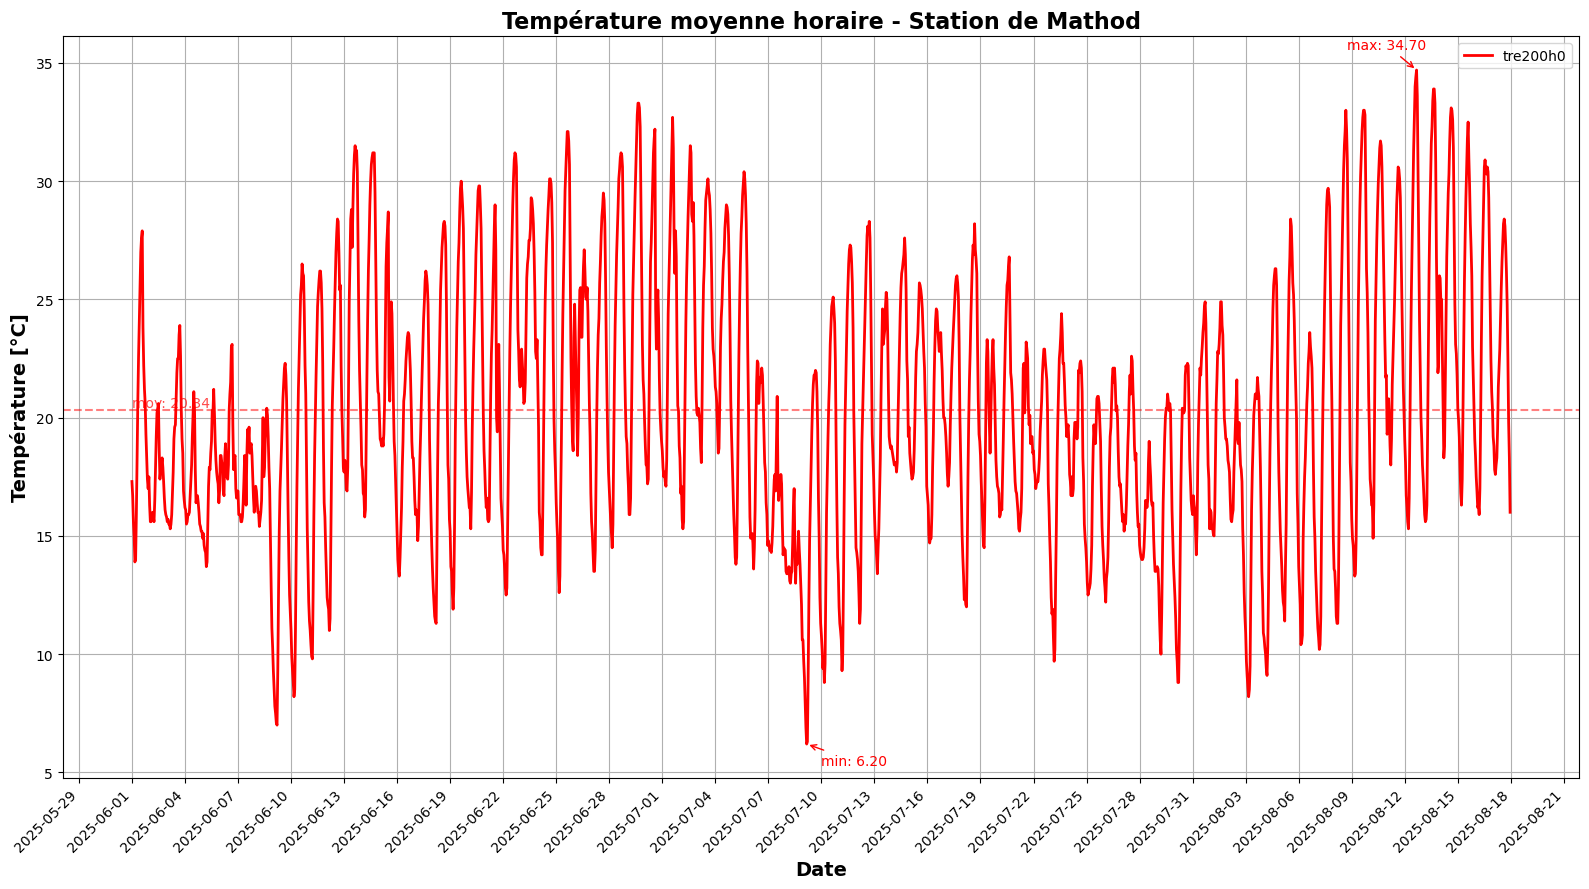

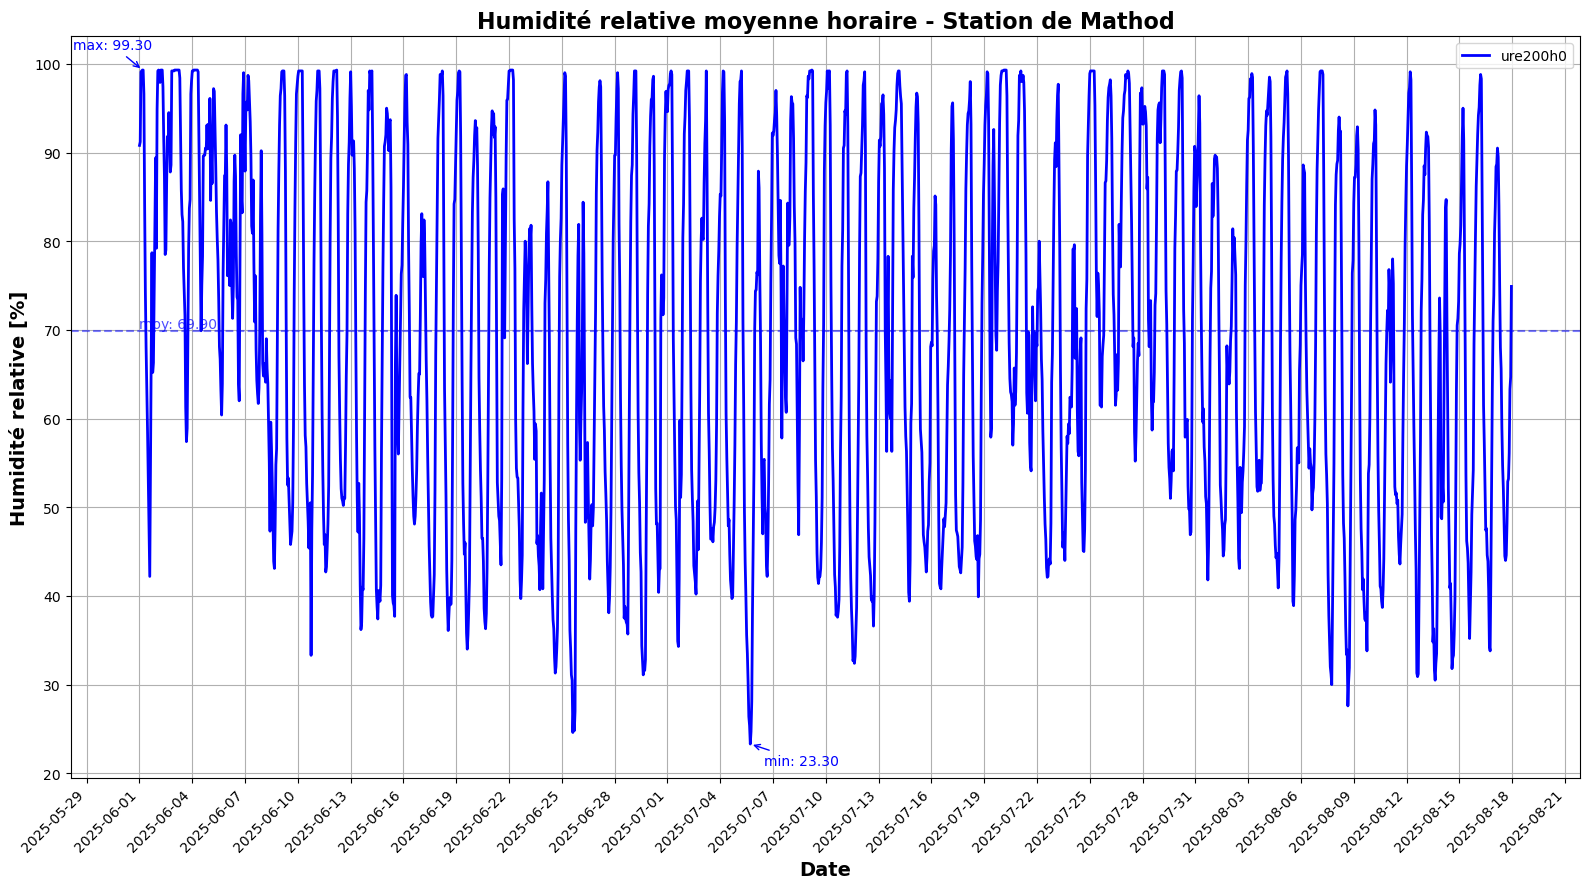

ModuleNotFoundError: No module named 'windrose'

In [2]:
# =============================
# 1. Fonctions graphiques optimisées
# =============================
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Couleurs personnalisées pour les paramètres
CUSTOM_COLORS = {
    'tre200h0': 'red',    # Température en rouge
    'ure200h0': 'blue',   # Humidité en bleu
    'fkl010h1': 'green'   # Vent en vert
}


def format_time_axis(ax, interval_days=3):
    """Formate l'axe X pour un affichage des dates propre avec labels lisibles."""
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval_days))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.grid(True)

def plot_time_series(df, x_col, y_cols, title, y_label, interval_days=3, show_stats=True):
    if isinstance(y_cols, str):
        y_cols = [y_cols]

    plt.figure(figsize=(16, 9))
    ax = plt.gca()

    for col in y_cols:
        if col not in df.columns:
            print(f"⚠ Colonne '{col}' introuvable dans DataFrame")
            continue

        color = CUSTOM_COLORS.get(col, None)
        data = df[[x_col, col]].dropna()
        sns.lineplot(data=data, x=x_col, y=col, ax=ax, label=col, color=color, linewidth=2)

        if show_stats and not data.empty:
            y_min = data[col].min()
            y_max = data[col].max()
            y_mean = data[col].mean()
            x_min = data.loc[data[col].idxmin(), x_col]
            x_max = data.loc[data[col].idxmax(), x_col]

            ax.annotate(f"min: {y_min:.2f}", xy=(x_min, y_min),
                        xytext=(10, -15), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->", color=color),
                        fontsize=10, color=color)
            ax.annotate(f"max: {y_max:.2f}", xy=(x_max, y_max),
                        xytext=(-50, 15), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->", color=color),
                        fontsize=10, color=color)

            ax.axhline(y=y_mean, linestyle='--', color=color, alpha=0.5)
            ax.text(data[x_col].min(), y_mean, f"moy: {y_mean:.2f}", color=color,
                    fontsize=10, va='bottom', ha='left', alpha=0.7)

    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Date", fontsize=14, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
    format_time_axis(ax, interval_days)
    plt.show()

def plot_wind_rose(df, dir_col, speed_col, title="Rose des Vents", bins=6):
    from windrose import WindroseAxes

    if dir_col not in df.columns or speed_col not in df.columns:
        print(f"⚠ Colonnes '{dir_col}' ou '{speed_col}' introuvables")
        return

    df_wind = df[[dir_col, speed_col]].dropna()
    if df_wind.empty:
        print("⚠ Pas de données valides pour la rose des vents")
        return

    plt.figure(figsize=(10, 10))
    ax = WindroseAxes.from_ax()

    colors = sns.light_palette("green", n_colors=bins, reverse=False)
    colors = [(r, g, b, 0.7) for r, g, b in colors]

    ax.bar(df_wind[dir_col], df_wind[speed_col], normed=True, opening=0.8, edgecolor='white', bins=bins, colors=colors)
    ax.set_title(title, fontsize=16, fontweight='bold')
    plt.show()


# =============================
# 2. Utilisation (exemples)
# =============================

# Graphique température
plot_time_series(df, 'timestamp', 'tre200h0',
                 "Température moyenne horaire - Station de Mathod",
                 "Température [°C]")

# Graphique humidité relative
plot_time_series(df, 'timestamp', 'ure200h0',
                 "Humidité relative moyenne horaire - Station de Mathod",
                 "Humidité relative [%]")

# Rose des vents
plot_wind_rose(df, 'dkl010h0', 'fkl010h1')

# Vitesse moyenne du vent
plot_time_series(df, 'timestamp', 'fkl010h1',
                 "Vitesse moyenne du vent - Station de Mathod",
                 "Vitesse du vent [km/h]")
